In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import numpy as np
import cv2
import tifffile as tiff

from oiffile import OifFile

Using OpenCL device NVIDIA RTX A5000


In [2]:
class OifImageViewer:
    
    # Channel 0: NG2+ cells
    # Channel 1: CD144 (blood vessel)
    
    def __init__(self, oif: OifFile) -> None:
        self.arr = oif.asarray()
        self.img_shape = self.arr.shape[2:]
        self.figsize = (25,25)
        print(self.__str__())
        
    def get_image(self, ch=0, z=0, beta=255) -> np.ndarray:
        return normalize(self.arr[ch][z], beta=beta)
    
    def get_x_slice(self, x, ch=0, beta=255):
        """
        Return image slice through specified x value
        """
        return normalize(self.arr[ch][:, :, x], beta=beta)
    
    def get_y_slice(self, y, ch=0, beta=255):
        """
        Return image slice through specified x value
        """
        return normalize(self.arr[ch][:, y, :], beta=beta)

    def show_image(self, image, color=-1, origin="upper") -> None:
        plt.figure(figsize=self.figsize)
        if color > -1:
            color_image = np.zeros((*self.img_shape, 3), dtype=np.uint16)
            color_image[:,:,color] = image
            plt.imshow(color_image)
            return
        plt.imshow(BGR2RGB(image))
        
    def combined_image(self, z=0) -> None:
        plt.figure(figsize=self.figsize)
        color_image = np.zeros((*self.img_shape, 3), dtype=np.uint16)
        for n_ch, arr_ch in enumerate(self.arr):
            color_image[:,:,n_ch] = self.normalize(arr_ch[z])
        plt.imshow(color_image)
        
    def __str__(self):
        return (
            f"Image shape: {self.arr.shape}\n"
            "Axes: CZYX\n"
            f"Dtype: {self.arr.dtype}\n"
        )
        

def normalize(image, beta=255):
    # 0-255 for uint8
    # 0-65535 for uint16
    dtype = "uint8" if beta == 255 else "uint16"
    return cv2.normalize(
        image, 
        dst=None, 
        alpha=0, 
        beta=beta, 
        norm_type=cv2.NORM_MINMAX
    ).astype(dtype)


def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    


In [3]:
path = "/home/dkermany/data/Bone_Project/FV10__20190620_111343/stiched.oib"

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16



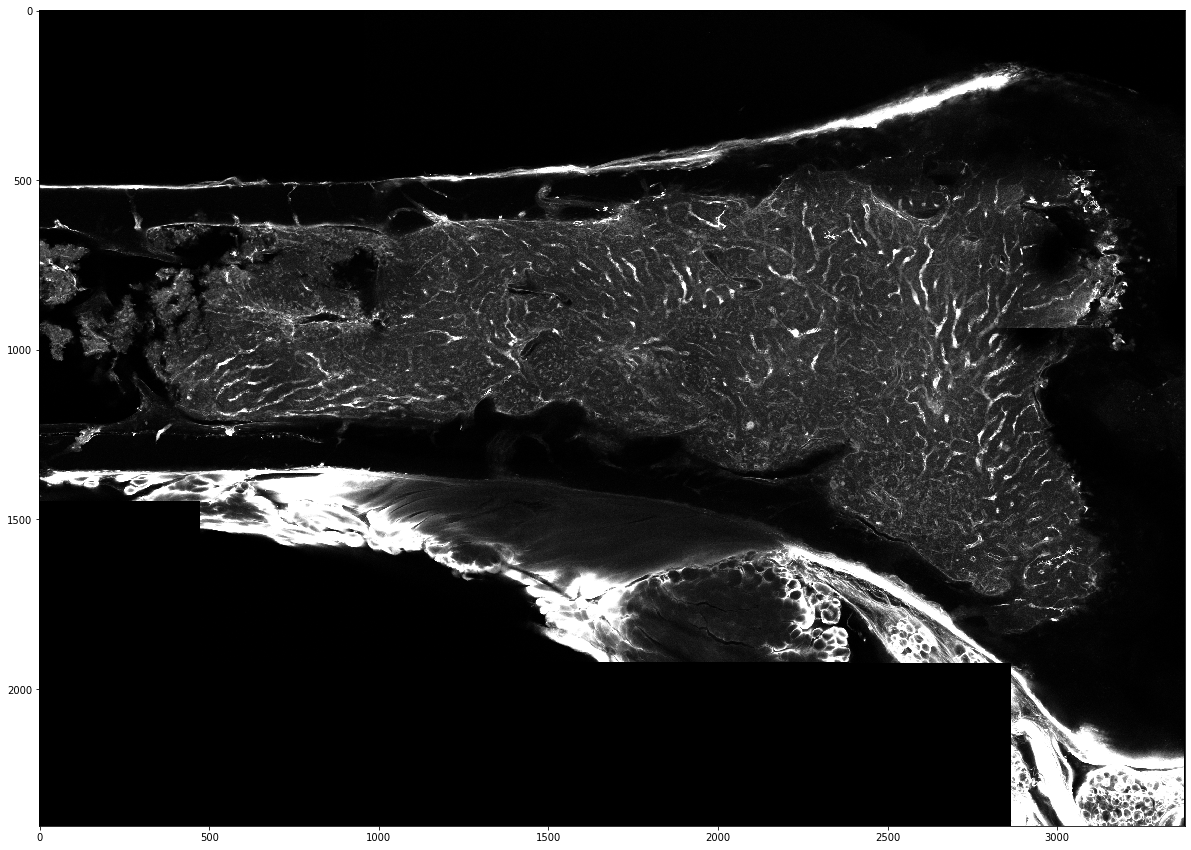

In [4]:
original_image = cle.push(viewer.arr[1])

plt.figure(figsize=(30,15))
cle.imshow(original_image[40])

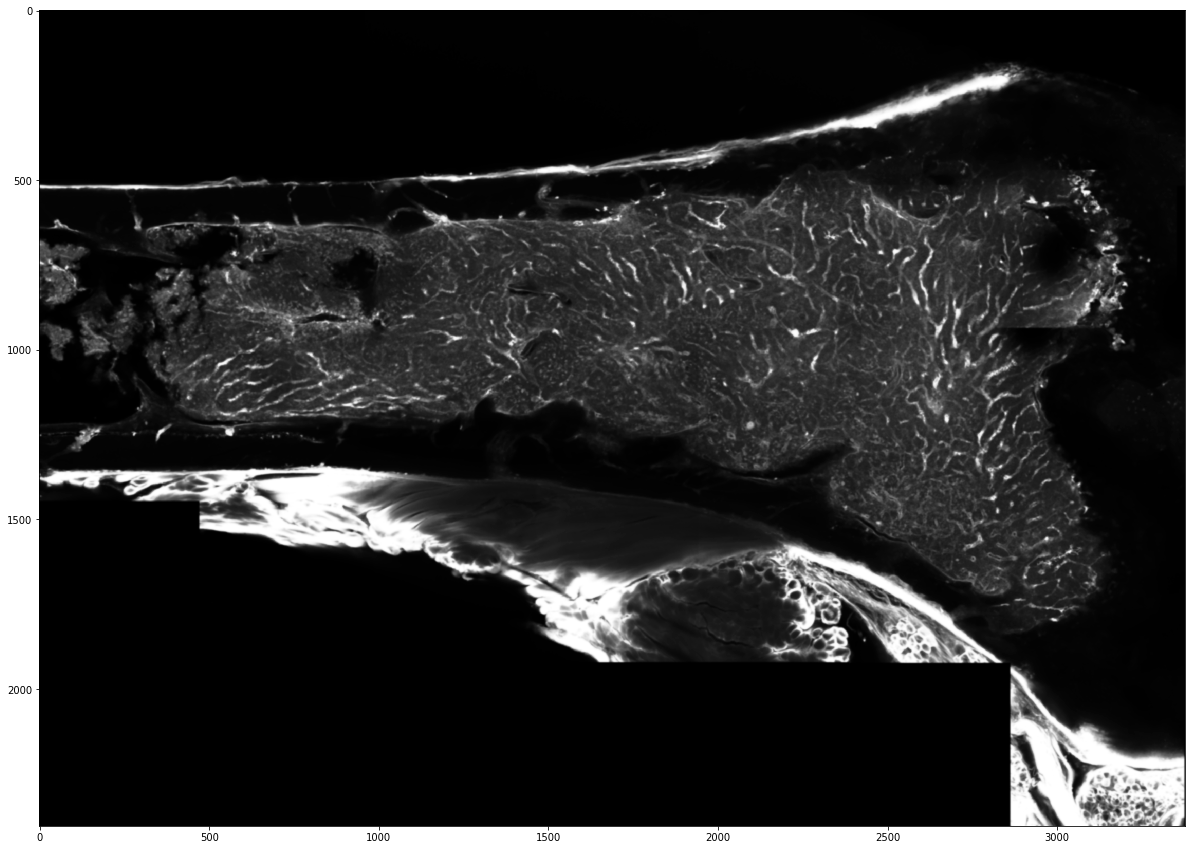

In [5]:
img_gaussian = cle.gaussian_blur(original_image, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian[40])

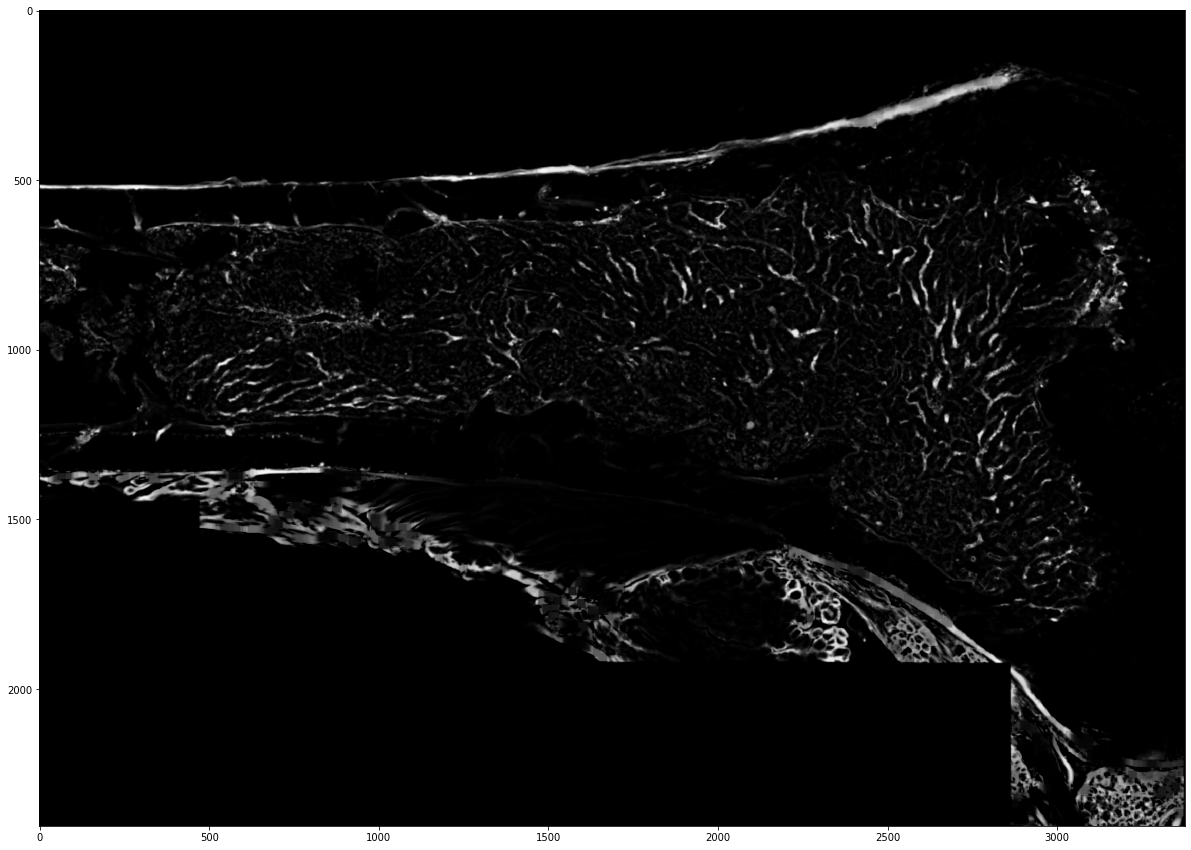

In [6]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted[40])

In [7]:
# thicker_membranes = cle.maximum_sphere(backgrund_subtracted, radius_x=3, radius_y=3, radius_z=3)

# plt.figure(figsize=(30,15))
# cle.imshow(thicker_membranes[40])

In [8]:
# thresh1 = cle.threshold_otsu(thicker_membranes)

# plt.figure(figsize=(30,15))
# cle.imshow(thresh1[40])

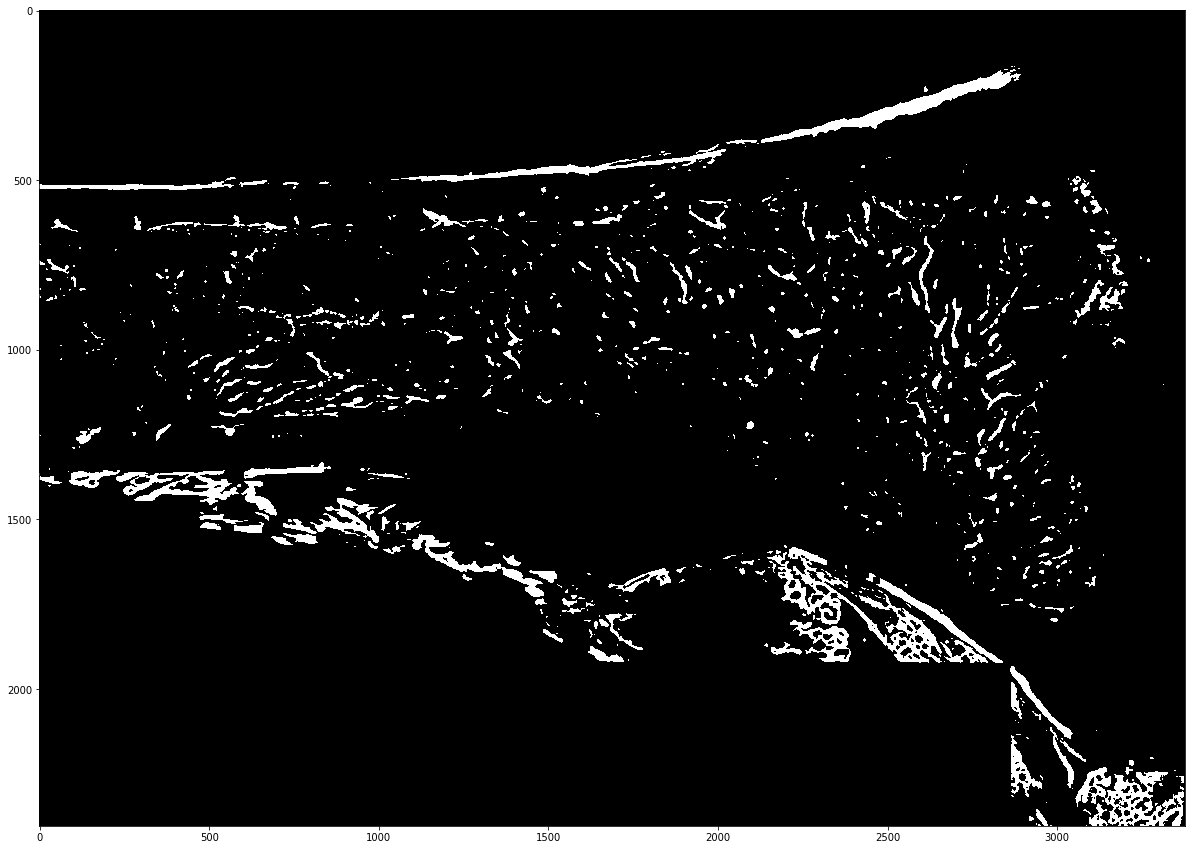

In [9]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(30,15))
cle.imshow(thresh2[40])

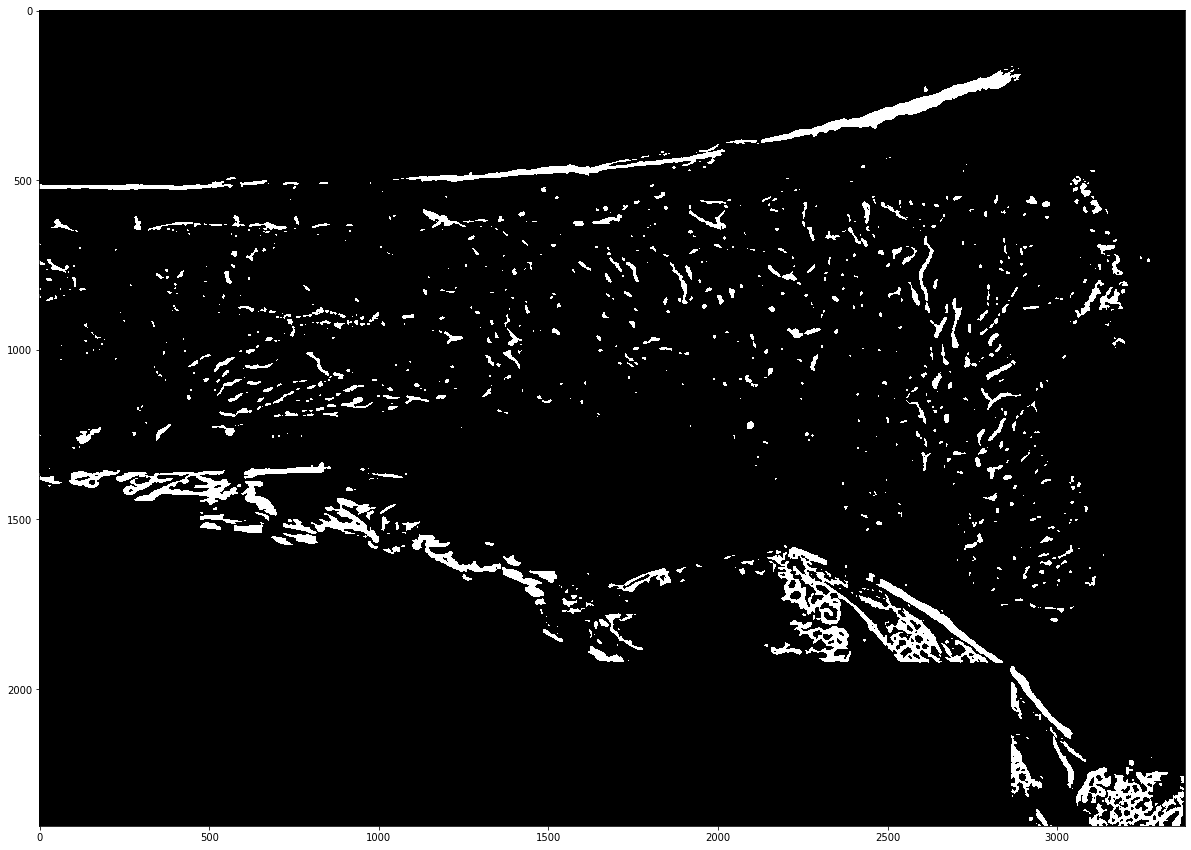

In [36]:
# Morphological openning
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation[40])

In [46]:

dilation.shape

(76, 2404, 3376)

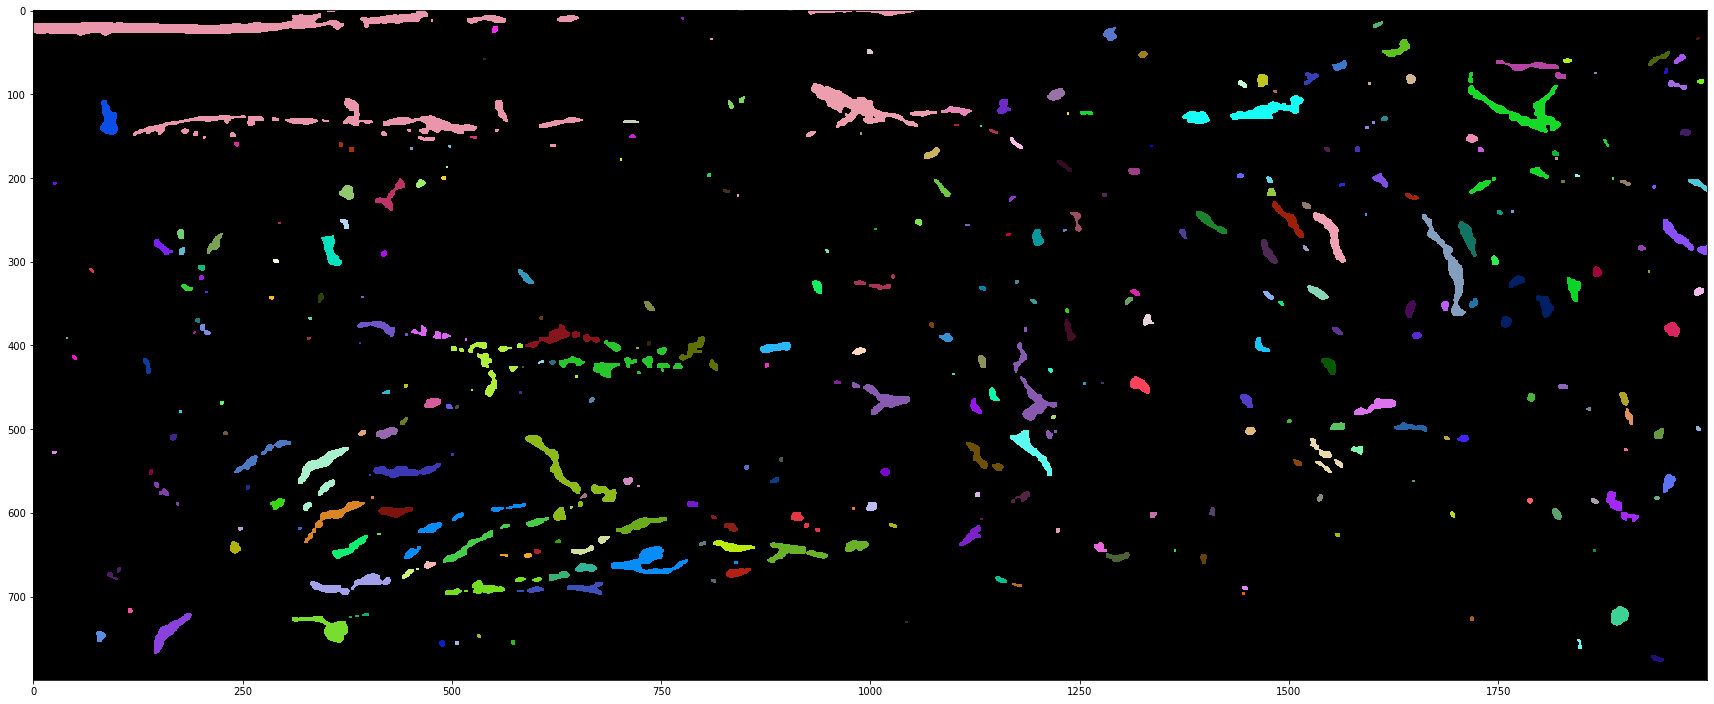

In [55]:
labels = cle.connected_components_labeling_box(dilation[:, 500:1300, 200:2200])

plt.figure(figsize=(30,15))
cle.imshow(labels[40], labels=True)


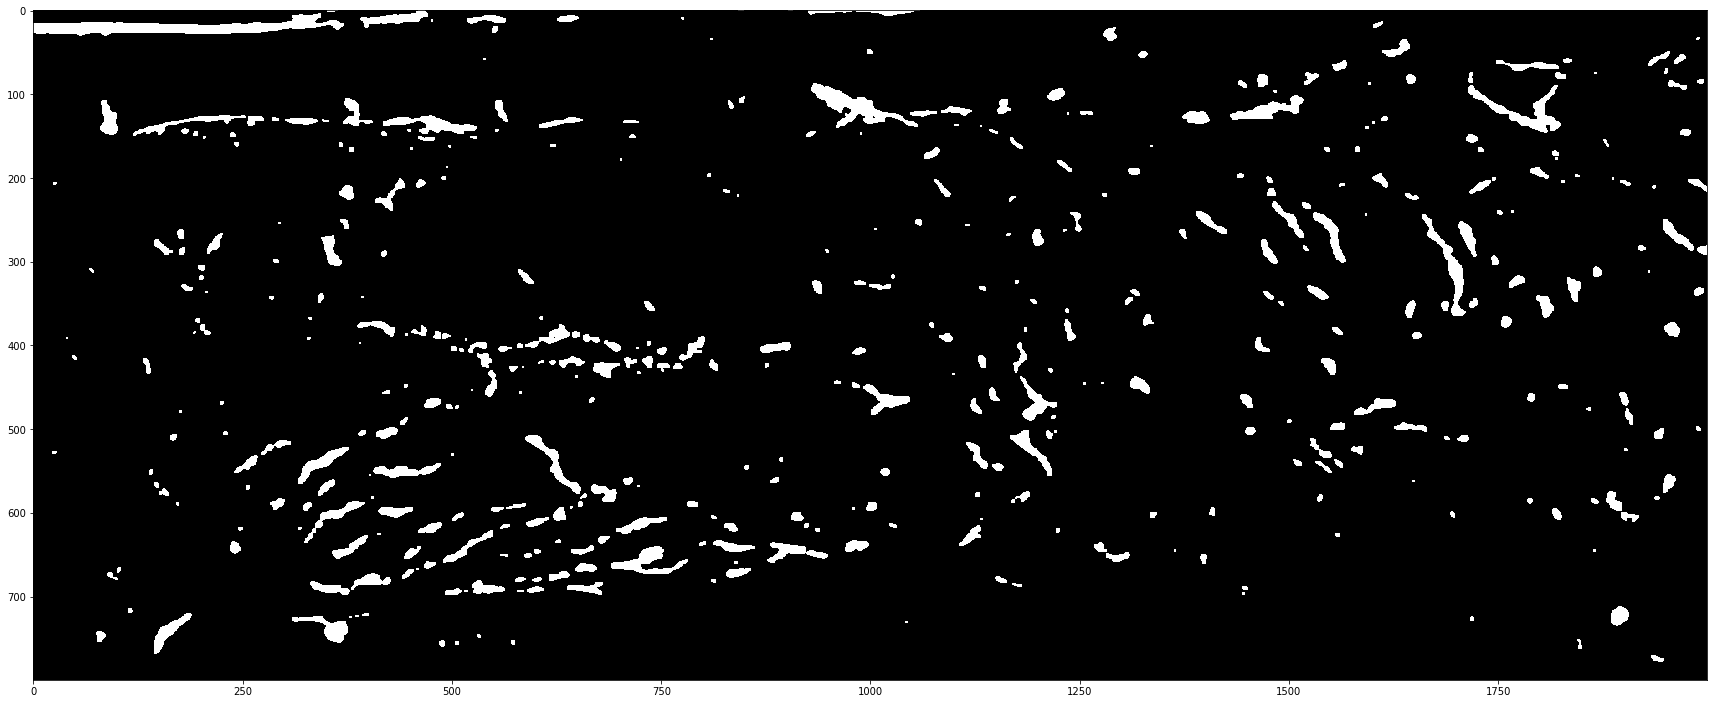

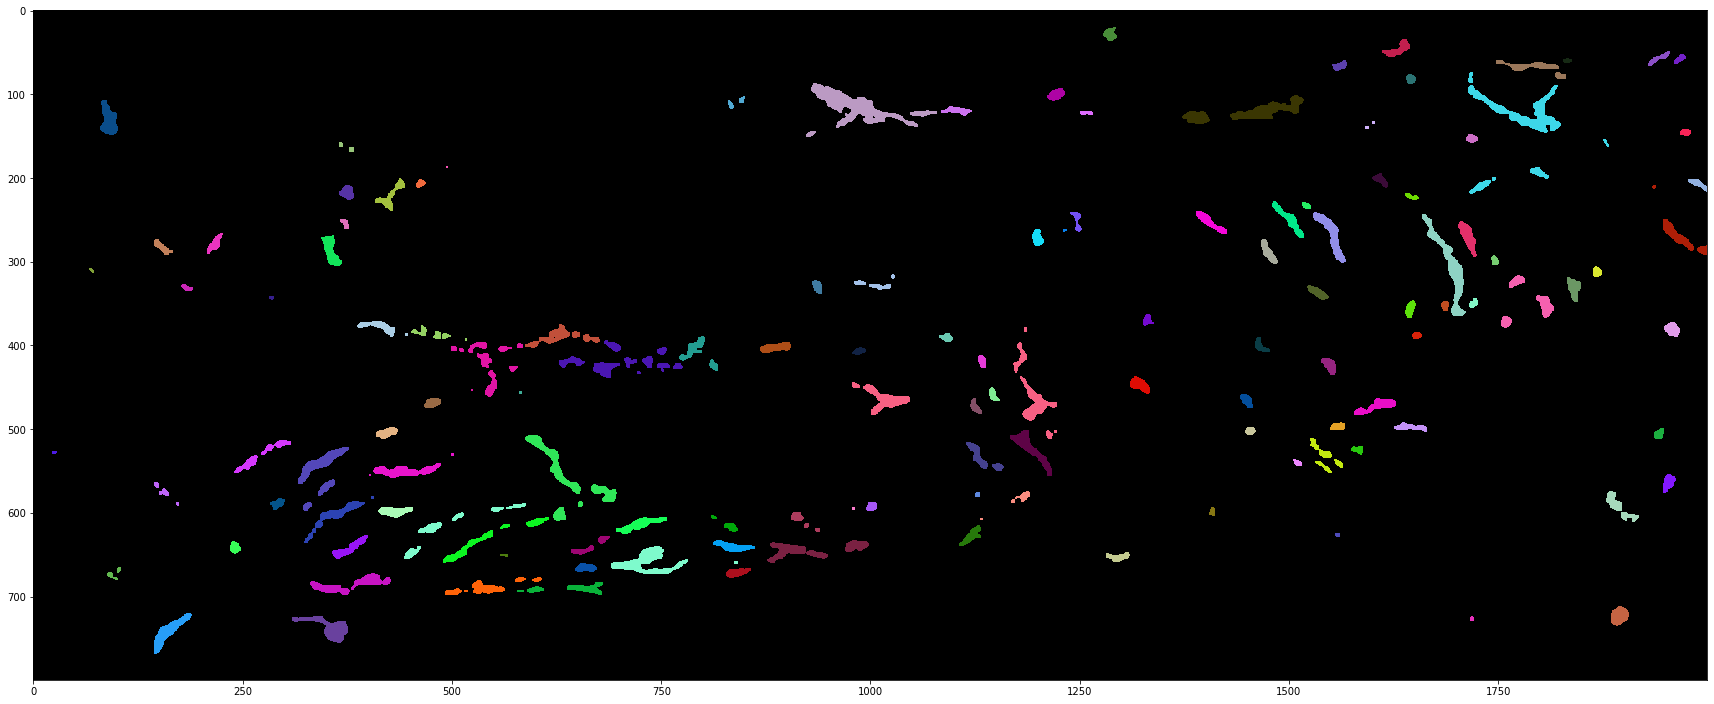

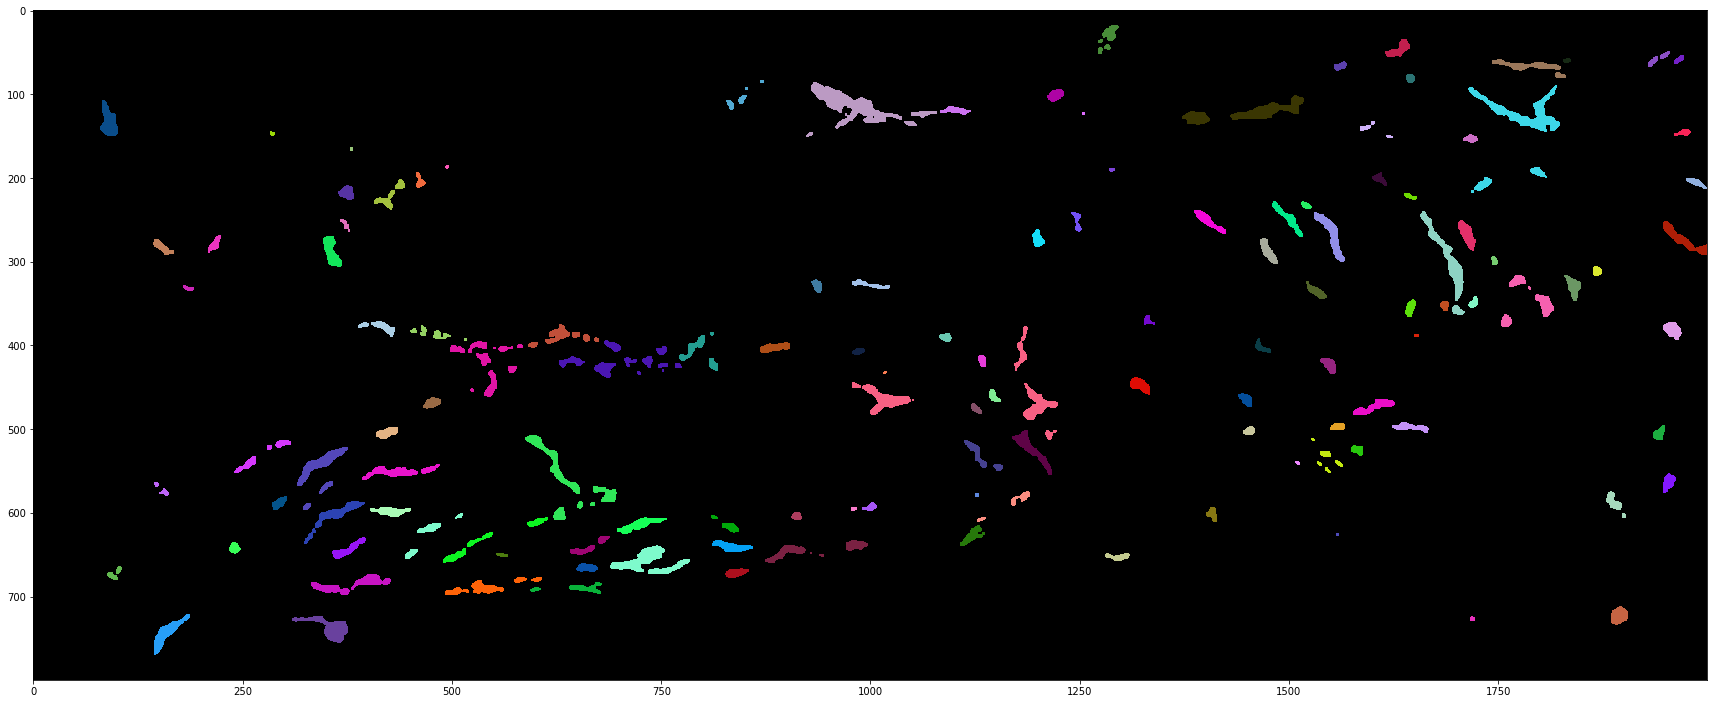

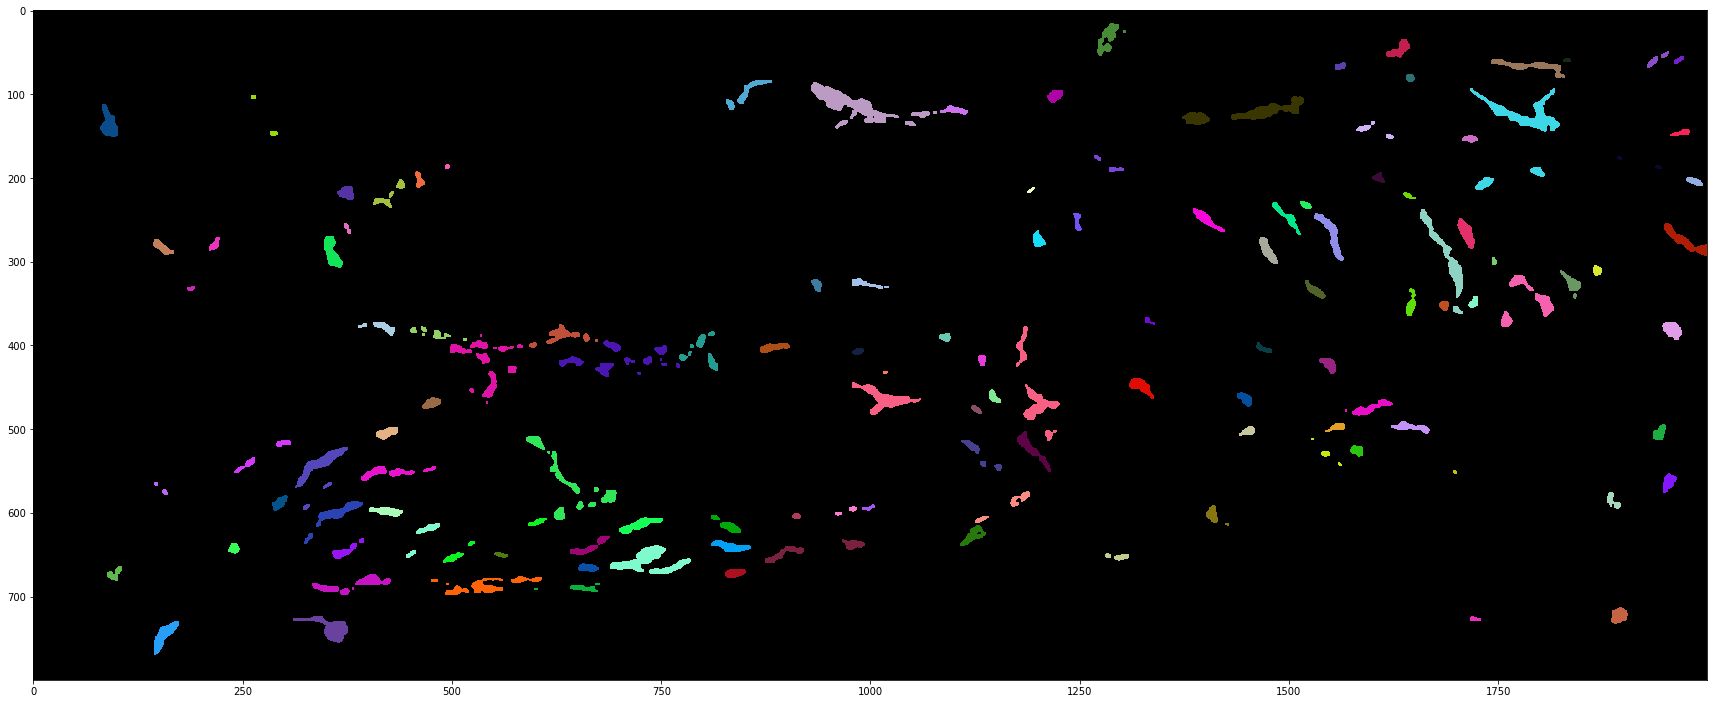

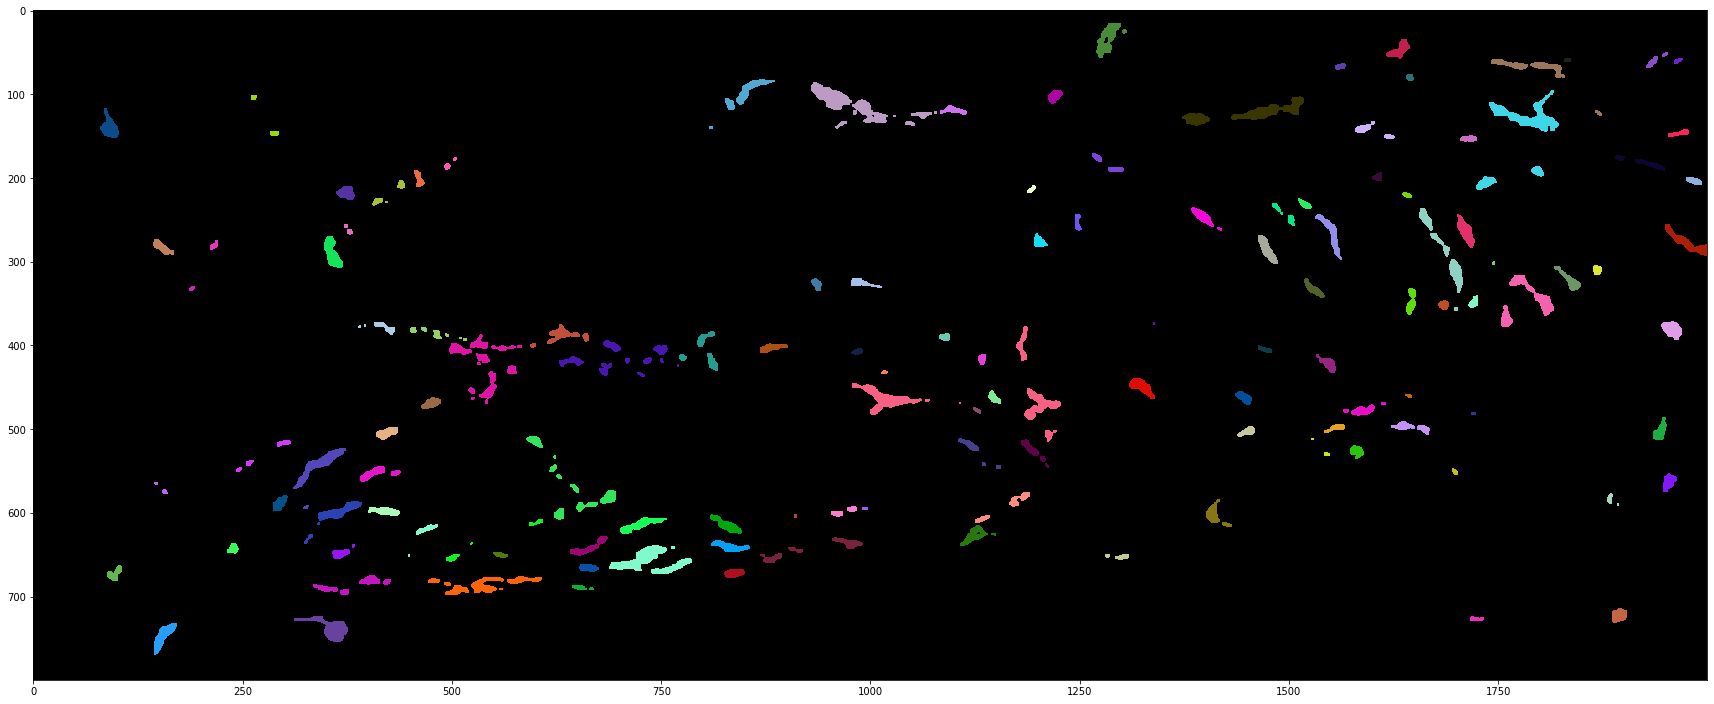

In [84]:
plt.figure(figsize=(30,15))
cle.imshow(dilation[40, 500:1300, 200:2200], labels=False)

smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 2000, 1000000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[40], labels=True)

plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[41], labels=True)

plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[42], labels=True)

plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[43], labels=True)

In [61]:
cle.exclude_labels_outside_size_range.__doc__

'Removes labels from a label map which are not within a certain size range.\n    \n    Size of the labels is given as the number of pixel or voxels per label. \n    \n    Parameters\n    ----------\n    source : Image\n    destination : Image, optional\n    minimum_size : Number, optional\n    maximum_size : Number, optional\n    \n    Returns\n    -------\n    destination\n    \n    References\n    ----------\n    .. [1] https://clij.github.io/clij2-docs/reference_excludeLabelsOutsideSizeRange\n    '